In [1]:
%cd ..

/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark


In [2]:
import sys
sys.path.append('/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark')

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import glob
import os
import os.path as op
import random
import time
import warnings
warnings.filterwarnings("ignore")

import h5py
from joblib import Parallel, delayed
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

from mri.numerics.gradient import GradAnalysis2

from data import from_train_file_to_image_and_kspace, from_test_file_to_mask_and_kspace, ZeroFilled2DSequence
from evaluate import METRIC_FUNCS, Metrics
from fourier import FFT2
from utils import gen_mask, keras_psnr, keras_ssim
from reconstruction import reco_wav, reco_z_filled, reco_unet_from_test_file, reco_iterative_from_test_file

Using TensorFlow backend.



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=0.18.0  - required | 1.3.0     installed
numpy          : >=1.11.0  - required | 1.16.4    installed
matplotlib     : >=2.0.0   - required | 3.1.0     installed
future         : >=0.16.0  - required | 0.17.1    installed
astropy        : ==2.0.8   - required | 2.0.8     installed
nibabel        : >=2.1.0   - required | 2.4.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.1.5   - requi

In [4]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [5]:
fourier_op = FFT2(np.array([1]))

In [6]:
val_path = '/media/Zaccharie/UHRes/singlecoil_val/'
val_reco_path = '/media/Zaccharie/UHRes/singlecoil_val_reco/'
val_filenames = glob.glob(val_path + '*')

In [7]:
test_path = '/media/Zaccharie/UHRes/singlecoil_test/'
test_reco_path = '/media/Zaccharie/UHRes/singlecoil_test_reco/'
test_filenames = glob.glob(test_path + '*')

In [8]:
AF = 8

In [15]:
val_gen = ZeroFilled2DSequence(val_path, mode='validation', af=AF, norm=True)
test_gen = ZeroFilled2DSequence(test_path, mode='testing', af=AF, norm=True)

In [11]:
def reco_from_val_file(filename, accel_factor=AF, **kwargs):
    images, kspaces = from_train_file_to_image_and_kspace(filename)
    # mask gen
    fake_kspace = np.zeros_like(kspaces[0])
    mask = gen_mask(fake_kspace, accel_factor=accel_factor)
    fourier_mask = np.repeat(mask.astype(np.float), fake_kspace.shape[0], axis=0)
    # op creation
    fourier_op_masked = FFT2(mask=fourier_mask)
    masked_kspace = fake_kspace * fourier_mask
    gradient_op = GradAnalysis2(
        data=masked_kspace,
        fourier_op=fourier_op_masked,
    )
    im_recos = np.array([reco_wav(kspace * fourier_mask, gradient_op, **kwargs) for kspace in kspaces[10:20]])
    return im_recos, images[10:20]

Mean of psnr: 27.655572112315
Mean of ssim: 0.60

For mu=5*1e-8,  4 scales, db4, 20 iterations in 1h43 mins

Mean of psnr: 29.5
Mean of ssim: 0.65

For zero-filled

In [12]:
def metrics_for_args(rec, file_prop=0.2, **rec_kwargs):
    metrics = Metrics(METRIC_FUNCS)
    sample_val_filenames = random.sample(val_filenames, int(file_prop * len(val_filenames)))
    pred_and_gt = Parallel(n_jobs=-1, backend='loky')(
        delayed(rec)(val_file, **rec_kwargs) 
        for val_file in tqdm_notebook(sample_val_filenames)
    )
    
    for im_recos, images in tqdm_notebook(pred_and_gt, desc='Stats'):
        metrics.push(images, im_recos)
    return metrics

For wavelet reco:
- multiprocessing: 4'
- loky: 4'
- multithreading: 4'

In [13]:
max_iters = [15]
metrics_list = []
for max_iter in tqdm_notebook(max_iters):
    print('Testing', max_iter)
    metrics = metrics_for_args(reco_wav, mu=1e-8, max_iter=max_iter, file_prop=0.2)
    metrics_list.append(metrics)

Testing 15


TypeError: reco_wav() missing 1 required positional argument: 'gradient_op'

<IPython.core.display.Javascript object>


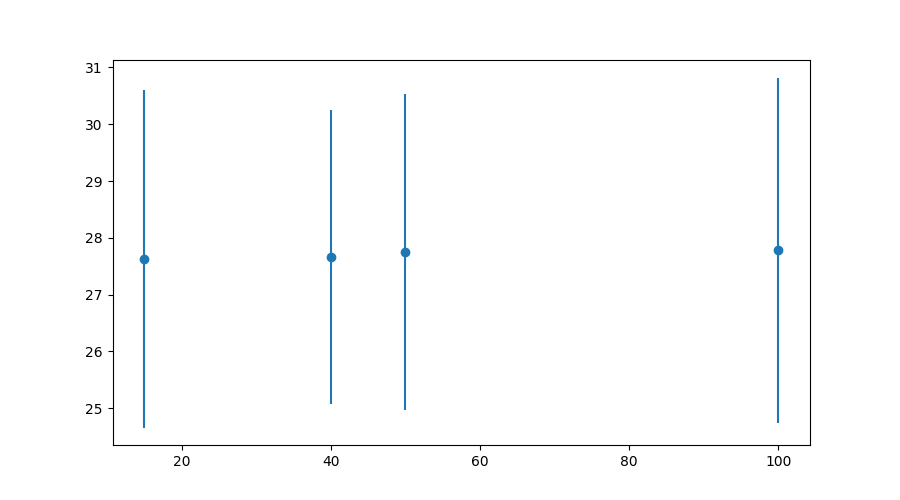

<ErrorbarContainer object of 3 artists>

In [20]:
plt.figure()
plt.errorbar(
    max_iters, 
    [metrics.metrics['PSNR'].mean() for metrics in metrics_list], 
    [metrics.metrics['PSNR'].stddev() for metrics in metrics_list],
    linestyle='None', 
    marker='o',
)

<IPython.core.display.Javascript object>


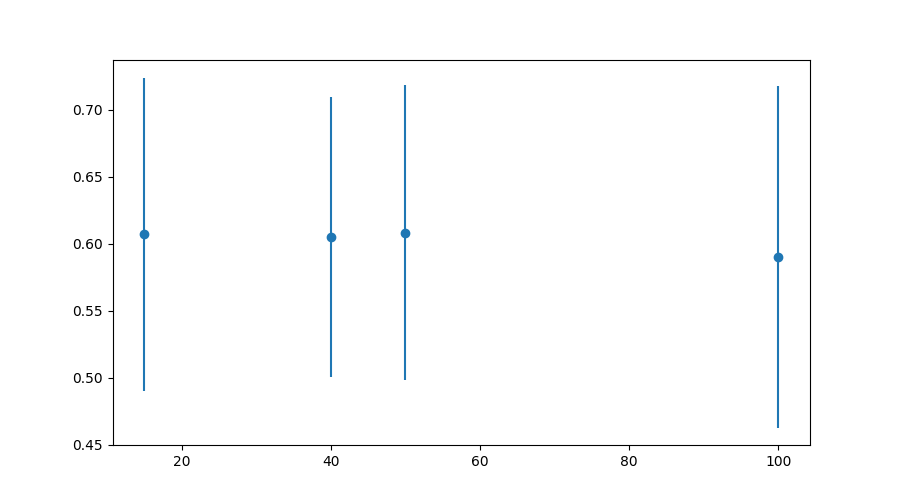

<ErrorbarContainer object of 3 artists>

In [21]:
plt.figure()
plt.errorbar(
    max_iters, 
    [metrics.metrics['SSIM'].mean() for metrics in metrics_list], 
    [metrics.metrics['SSIM'].stddev() for metrics in metrics_list],
    linestyle='None', 
    marker='o',
)

In [26]:
n_exp = 10
mus = np.logspace(-6, -5, n_exp)
# mus = [8*1e-8]
metrics_list = []
for mu in tqdm_notebook(mus):
    print('Testing', mu)
    metrics = metrics_for_args(mu=mu, max_iter=15, file_prop=0.2)
    metrics_list.append(metrics)

Testing 1e-06


Testing 1.2915496650148827e-06


Testing 1.6681005372000591e-06


Testing 2.1544346900318822e-06


Testing 2.782559402207126e-06


Testing 3.5938136638046257e-06


Testing 4.641588833612782e-06


Testing 5.994842503189409e-06


Testing 7.742636826811277e-06


Testing 1e-05


<IPython.core.display.Javascript object>


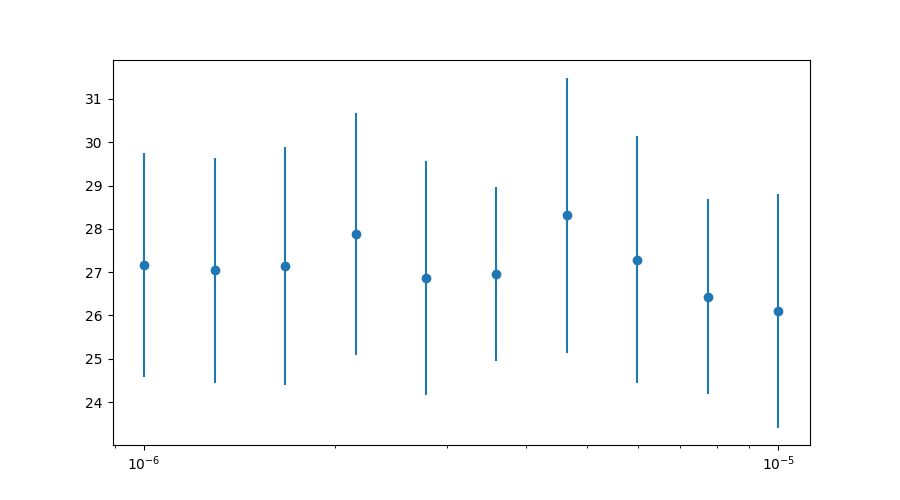

In [27]:
plt.figure()
plt.errorbar(
    mus, 
    [metrics.metrics['PSNR'].mean() for metrics in metrics_list], 
    [metrics.metrics['PSNR'].stddev() for metrics in metrics_list],
    linestyle='None', 
    marker='o',
)
plt.xscale('log')

<IPython.core.display.Javascript object>


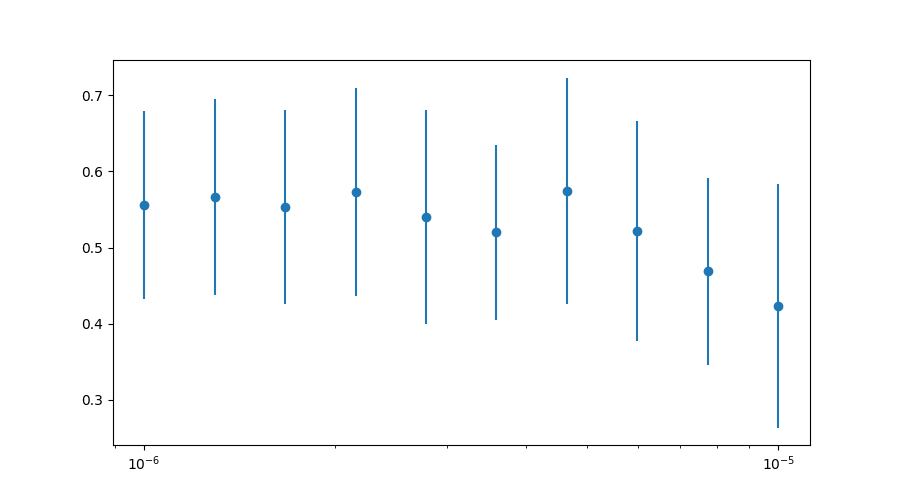

In [28]:
plt.figure()
plt.errorbar(
    mus, 
    [metrics.metrics['SSIM'].mean() for metrics in metrics_list], 
    [metrics.metrics['SSIM'].stddev() for metrics in metrics_list],
    linestyle='None', 
    marker='o',
)
plt.xscale('log')

In [23]:
n_exp = 20
mus = np.logspace(-9, -3, n_exp)
# mus = [8*1e-8]
metrics_list = []
for mu in tqdm_notebook(mus):
    print('Testing', mu)
    metrics = metrics_for_args(mu=mu, max_iter=15, file_prop=0.2)
    metrics_list.append(metrics)

Testing 1e-09


Testing 2.06913808111479e-09


Testing 4.281332398719396e-09


Testing 8.858667904100832e-09


Testing 1.8329807108324374e-08


Testing 3.792690190732254e-08


Testing 7.847599703514607e-08


Testing 1.623776739188721e-07


Testing 3.359818286283781e-07


Testing 6.951927961775605e-07


Testing 1.438449888287663e-06


Testing 2.976351441631313e-06


Testing 6.158482110660255e-06


Testing 1.274274985703132e-05


Testing 2.6366508987303556e-05


Testing 5.4555947811685143e-05


Testing 0.00011288378916846884


Testing 0.00023357214690901214


Testing 0.0004832930238571752


Testing 0.001


<IPython.core.display.Javascript object>


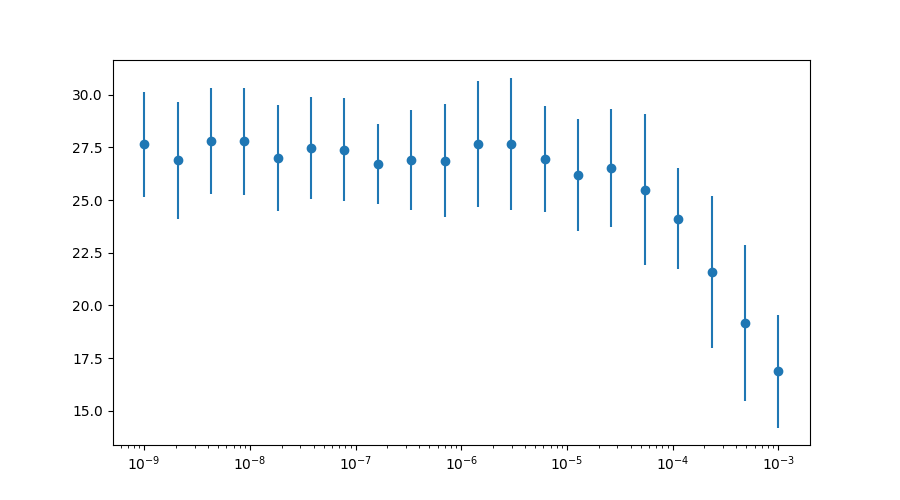

In [24]:
plt.figure()
plt.errorbar(
    mus, 
    [metrics.metrics['PSNR'].mean() for metrics in metrics_list], 
    [metrics.metrics['PSNR'].stddev() for metrics in metrics_list],
    linestyle='None', 
    marker='o',
)
plt.xscale('log')

<IPython.core.display.Javascript object>


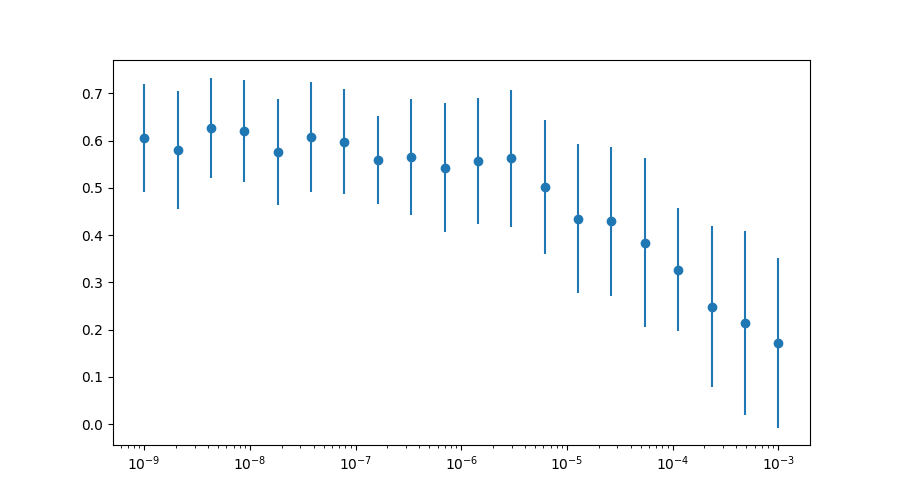

In [25]:
plt.figure()
plt.errorbar(
    mus, 
    [metrics.metrics['SSIM'].mean() for metrics in metrics_list], 
    [metrics.metrics['SSIM'].stddev() for metrics in metrics_list],
    linestyle='None', 
    marker='o',
)
plt.xscale('log')

# Test inference

In [10]:
def filename_submission(filename):
    relative_filename = filename.split('/')[-1]
    name = relative_filename.split('.')[0]
    name += '_v2.h5'
    return name

## Iterative

In [42]:
reco_type = 'zero_filled'

In [44]:
def reco_and_save_iterative(filename, path, rec_type='wav', **kwargs):
    im_recos = reco_iterative_from_test_file(filename, rec_type=rec_type, **kwargs)
    im_crops = [np.abs(crop_center(im_reco, 320)) for im_reco in im_recos]
    im_crops = np.array(im_crops)
    with h5py.File(op.join(path, reco_type, filename_submission(filename)), 'w') as f:
            f.create_dataset('reconstruction', data=im_crops)

In [22]:
# Parallel(n_jobs=-1, backend='multiprocessing', batch_size=len(test_filenames)//40)(
#     delayed(reco_and_save_iterative)(filename, test_reco_path, rec_type='wav') for filename in tqdm_notebook(test_filenames)
# );

## Unet

In [11]:
reco_type = 'unet'

In [12]:
run_id = 'af8_test'
epoch = 50
chkpt_path = f'checkpoints/{run_id}-{epoch}.hdf5'
unet = load_model(chkpt_path, custom_objects={'keras_psnr': keras_psnr,'keras_ssim': keras_ssim})

W0729 11:19:52.589344 140278320183040 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 11:19:52.744259 140278320183040 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0729 11:19:52.769317 140278320183040 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0729 11:19:52.842710 140278320183040 deprecation_wrapper.py:119] From /volatile/home/Zaccharie/workspace/fastm

In [13]:
def reco_and_save_unet(zero_img_batch, means, stddevs, model, path, filename):
    im_recos = reco_unet_from_test_file(zero_img_batch, means, stddevs, model)
    with h5py.File(op.join(path, reco_type, filename_submission(filename)), 'w') as f:
            f.create_dataset('reconstruction', data=im_recos)

In [16]:
Parallel(n_jobs=1, backend='multiprocessing', batch_size=len(test_filenames)//40)(
    delayed(reco_and_save_unet)(*test_gen[i], unet, test_reco_path, test_gen.filenames[i]) 
    for i in tqdm_notebook(range(len(test_gen)))
);